In [1]:
%load_ext autoreload
%autoreload 2

In [55]:
from multiprocessing import cpu_count, Pool
import time
from typing import Callable, Tuple

import jax
import jax.numpy as jnp
from jax.scipy.optimize import minimize as jminimize
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize_scalar, root_scalar
from tqdm import tqdm, trange

from pydd.analysis import *
from pydd.binary import *
from pydd.noise import *

Array = jnp.ndarray
RHO_S_PBH = 1.798e4 * MSUN / PC ** 3
GAMMA_S_PBH = 9 / 4

## Setup

In [9]:
# Set up the signal system
S_n, F_RANGE_NOISE = S_n_aLIGO, f_range_aLIGO
FS = jnp.linspace(*F_RANGE_NOISE, 100_000)
M_1 = jnp.array(1 * MSUN)
M_2 = jnp.array(1e-3 * MSUN)
M_CHIRP = get_M_chirp(M_1, M_2)
Q = M_2 / M_1
RHO_S = RHO_S_PBH
GAMMA_S = GAMMA_S_PBH
RHO_6 = get_rho_6(RHO_S, M_1, GAMMA_S)
TT_C = jnp.array(0.0)
F_C = get_f_isco(M_1)
PHI_C = jnp.array(0.0)
_DD_D = DynamicDress(
    GAMMA_S,
    RHO_6,
    get_M_chirp(M_1, M_2),
    M_2 / M_1,
    PHI_C,
    tT_c=TT_C,
    dL=jnp.array(100e6 * PC),
    f_c=get_f_isco(M_1),
)

# Get f_range
T_OBS = 1 * YR
F_RANGE_D = get_f_range(_DD_D, T_OBS)
# Get dL
SNR_THRESH = 12.0
_fn = jax.jit(
    lambda dL: calculate_SNR_cut(
        DynamicDress(
            _DD_D.gamma_s,
            _DD_D.rho_6,
            _DD_D.M_chirp,
            _DD_D.q,
            _DD_D.Phi_c,
            _DD_D.tT_c,
            dL,
            _DD_D.f_c,
        ),
        F_RANGE_D,
        FS,
        S_n,
    )
)
res = root_scalar(
    lambda dL: (_fn(dL) - SNR_THRESH), bracket=(0.1e6 * PC, 100000e6 * PC)
)
assert res.converged
DL = res.root

# System at correct distance
DD_D = DynamicDress(
    _DD_D.gamma_s,
    _DD_D.rho_6,
    _DD_D.M_chirp,
    _DD_D.q,
    _DD_D.Phi_c,
    _DD_D.tT_c,
    DL,
    _DD_D.f_c,
)

In [35]:
def replace_tT_c(dd, tT_c) -> DynamicDress:
    return DynamicDress(
        dd.gamma_s, dd.rho_6, dd.M_chirp, dd.q, dd.Phi_c, tT_c, dd.dL, dd.f_c
    )


def rho_6_nondim(rho_6):
    return rho_6 / (1e13 * MSUN / PC**3)


def rho_6_redim(rho_6_nd):
    return rho_6_nd * (1e13 * MSUN / PC**3)

In [65]:
# Various samplers and unpackers
def sample_Mc_tTc() -> Array:
    return jnp.array(
        [
            M_CHIRP / MSUN * (1 + 6e-8 * (np.random.rand(1) - 0.5)),
            0.0004 * (np.random.rand(1) - 0.5),
        ]
    )


def unpack_Mc_tTc(x: Array) -> DynamicDress:
    M_chirp_MSUN, tT_c = x
    M_chirp = M_chirp_MSUN * MSUN
    m_1 = get_m_1(M_chirp, DD_D.q)
    rho_6 = get_rho_6(RHO_S, m_1, DD_D.gamma_s)
    f_c = get_f_isco(m_1)
    return DynamicDress(
        DD_D.gamma_s, rho_6, M_chirp, DD_D.q, DD_D.Phi_c, tT_c, DD_D.dL, f_c
    )


# 1D
def sample_Mc() -> Array:
    return jnp.array(
        [M_CHIRP / MSUN * (1 + 6e-8 * (np.random.rand(1) - 0.5))]
    )


def unpack_Mc(x: Array) -> DynamicDress:
    M_chirp_MSUN = x[0]
    M_chirp = M_chirp_MSUN * MSUN
    m_1 = get_m_1(M_chirp, DD_D.q)
    rho_6 = get_rho_6(RHO_S, m_1, DD_D.gamma_s)
    f_c = get_f_isco(m_1)
    return DynamicDress(
        DD_D.gamma_s, rho_6, M_chirp, DD_D.q, DD_D.Phi_c, DD_D.tT_c, DD_D.dL, f_c
    )

In [15]:
@jax.jit
def ll_cut_fn(dd_h, f_range_h):
    """
    LL with correct frequency ranges. This is the deepest we can jit.
    """
    return loglikelihood_cut(dd_h, DD_D, f_range_h, F_RANGE_D, FS, S_n)


def ll_nomax_fn(
    x: Array, unpack: Callable[[Array], DynamicDress]
) -> Array:
    """
    Log-likelihood *without* tT_c maximization.
    """
    dd_h = unpack(x)
    f_range_h = get_f_range(dd_h, T_OBS)
    return ll_cut_fn(dd_h, f_range_h)


def ll_fn(
    x: Array,
    unpack: Callable[[Array], DynamicDress],
    bracket: Tuple[Array, Array] = (jnp.array(-1e-3), jnp.array(1e-3))
) -> Array:
    """
    Log-likelihood *with* tT_c maximization.
    """
    dd = unpack(x)

    def _nll(tT_c):
        """
        Negative log-likelihood.
        """
        dd_h = replace_tT_c(dd, tT_c)
        f_range_h = get_f_range(dd_h, T_OBS)
        return -ll_cut_fn(dd_h, f_range_h)

    res = minimize_scalar(_nll, bracket=bracket)
    assert res.success, f"tT_c maximization failed: {res}"
    return -res.fun

## Benchmark

In [12]:
print("Without tT_c maximization")
print("compiling and evaluating:", ll_nomax_fn(sample_Mc_tTc()))

n_loops = 3
t_start = time.time()
for _ in range(n_loops):
    ll_nomax_fn(sample_Mc_tTc()).block_until_ready()
print((time.time() - t_start) / n_loops)

Without tT_c maximization
compiling and evaluating: 71.64538769011027
0.20483191013336183


In [15]:
print("With tT_c maximization")
print("compiling and evaluating:", ll_fn(sample_Mc_tTc()))

n_loops = 3
t_start = time.time()
for _ in range(n_loops):
    ll_fn(sample_Mc()).block_until_ready()
print((time.time() - t_start) / n_loops)

With tT_c maximization
compiling and evaluating: -71.85888983416255
4.818462586402893


## 1D

In [26]:
Mcs = jnp.linspace(M_CHIRP / MSUN * (1 - 1e-7), M_CHIRP / MSUN * (1 + 1e-7), 100)
lls = jnp.array(list(map(lambda Mc: ll_fn([Mc]), Mcs)))

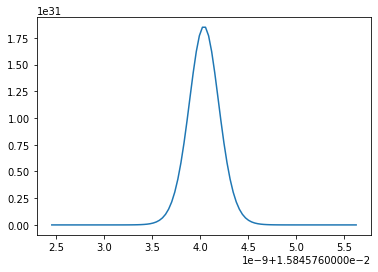

In [27]:
plt.plot(McsMc_MSUNsxp(lls))

## 2D

In [87]:
def sample_2d() -> Array:
    return jnp.array([
        M_CHIRP / MSUN * (1 + 1.25e-7 * 2 * (np.random.rand() - 0.5)),
        rho_6_nondim(RHO_6) * (1 + 6e-3 * 2 * (np.random.rand() - 0.5))
    ])


def unpack_2d(x: Array) -> DynamicDress:
    M_chirp_MSUN, rho_6_nd = x
    M_chirp = M_chirp_MSUN * MSUN
    rho_6 = rho_6_redim(rho_6_nd)
    f_c = get_f_isco(get_m_1(M_chirp, DD_D.q))
    return DynamicDress(
        DD_D.gamma_s, rho_6, M_chirp, DD_D.q, DD_D.Phi_c, DD_D.tT_c, DD_D.dL, f_c
    )

In [88]:
Mc_MSUNs = []
rho_6_nds = []
lls = []
for _ in trange(200):
    x = sample_2d()
    ll = ll_fn(x, unpack_2d)
    Mc_MSUNs.append(x[0])
    rho_6_nds.append(x[1])
    lls.append(ll)

Mc_MSUNs = jnp.array(Mc_MSUNs)
rho_6_nds = jnp.array(rho_6_nds)
lls = jnp.array(lls)


100%|██████████| 200/200 [09:15<00:00,  2.78s/it]


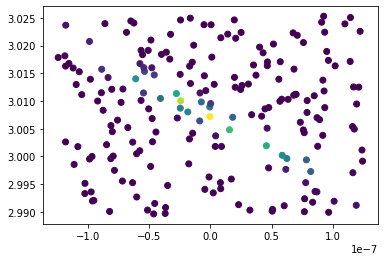

In [89]:
plt.scatter((Mc_MSUNs - M_CHIRP / MSUN) / (M_CHIRP / MSUN), rho_6_nds, c=jnp.exp(lls))